## Setup

In [1]:
import torch
import sys

from data.sequence import SequenceDataset
from model.diffusion import GaussianDiffusion
from model.temporal import TemporalUnet
from utils import Trainer
from visualization.eval_helpers import paint_trajectory
from visualization.rendering import SimplePhyreRenderer, PhyreTrajectoryRenderer
from tqdm import tqdm
import numpy as np
from visualization.eval_helpers import slider_animation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data

In [2]:
eval_dataset = "../datasets/phyre_diff_00_1_tasks_1_action_latents.h5"

dataset = SequenceDataset(eval_dataset)

[ datasets/buffer ] Finalized replay buffer | 1 episodes
[ datasets/buffer ] Fields:
    observations: (1, 200, 45)
    normed_observations: (1, 200, 45)


In [3]:
len(dataset)

1

In [4]:
observations = dataset[0][0]
reshaped_observations = np.reshape(observations, (-1, 3, 15))

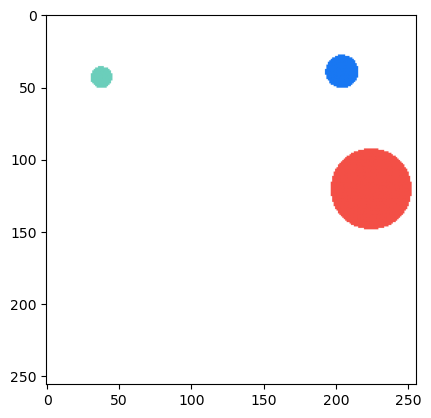

interactive(children=(IntSlider(value=0, description='t', max=63), Output()), _dom_classes=('widget-interact',…

In [5]:
slider_animation(paint_trajectory(reshaped_observations, return_frames=True, create_image=False))

## Model

In [6]:
observation_dim_per_object = 15
num_objects = 3

observation_dim = observation_dim_per_object * num_objects
horizon = 64

epochs = 1000

model = TemporalUnet(horizon=horizon, transition_dim=observation_dim, cond_dim=observation_dim)

diffusion = GaussianDiffusion(model, horizon=horizon, diffusion_dims=(0, 1, 15, 16, 30, 31), n_timesteps=30).to(device)

trainer = Trainer(diffusion, dataset, PhyreTrajectoryRenderer(), sample_freq=10000, log_freq=1000,
                  save_freq=10000, device=device)
trainer.load("../scripts/results/state_310.pt")

[ models/temporal ] Channel dimensions: [(45, 32), (32, 64), (64, 128), (128, 256)]
[(45, 32), (32, 64), (64, 128), (128, 256)]


In [7]:
model = trainer.model

In [8]:
observations = torch.tensor(observations)
observations = observations[None, :, :].to(device)

## Unconditioned Diffusion

torch.Size([1, 64, 45])
torch.Size([1, 64, 45])


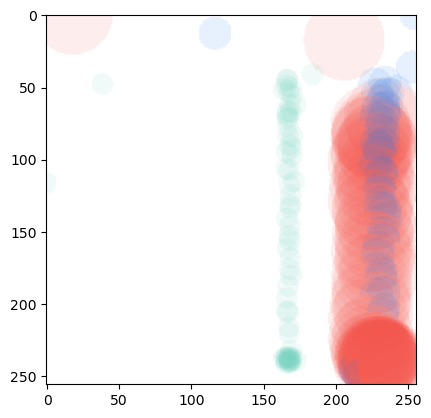

In [12]:
print(observations.shape)

trajectories, chain = model(observations, None, return_chain=True)
print(trajectories.shape)
reshaped_trajectory = np.reshape(trajectories.cpu(), (-1, 3, 15))
paint_trajectory(reshaped_trajectory)

## Conditioned Diffusion

torch.Size([64, 3, 15])
torch.Size([1, 3, 15])
(65, 3, 15)


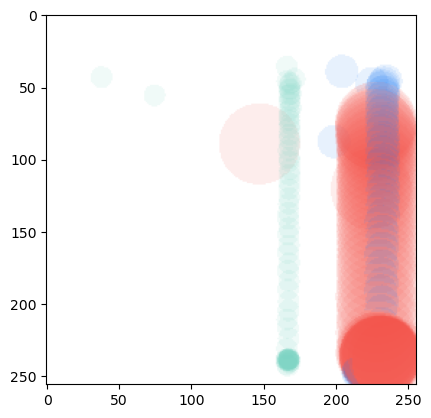

In [32]:
observations = dataset[0][0]
observations = torch.tensor(observations)
observations = observations[None, :, :].to(device)

conditions = dataset[0][1]
conditions = {
    key: torch.tensor(conditions[key]) for key in conditions
}

trajectories, chain = model(observations, conditions, return_chain=True)
reshaped_trajectory = np.reshape(trajectories.cpu(), (-1, 3, 15))
reshaped_conditions = np.reshape(conditions[0].cpu(), (-1, 3, 15))
full_trajectory = np.concatenate((reshaped_conditions, reshaped_trajectory), axis=0)

paint_trajectory(full_trajectory)

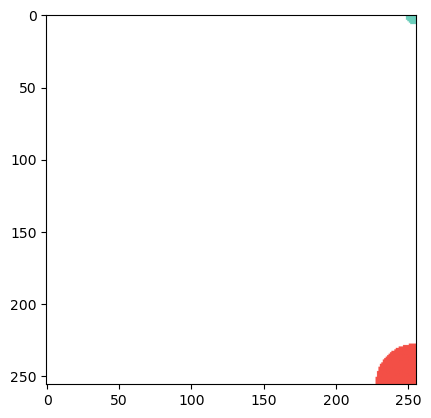

interactive(children=(IntSlider(value=0, description='t', max=63), Output()), _dom_classes=('widget-interact',…

In [15]:
slider_animation(paint_trajectory(full_trajectory, return_frames=True, create_image=False))